# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3891200/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:37 - loss: 0.6931

  30/1875 [..............................] - ETA: 3s - loss: 0.5385   

  63/1875 [>.............................] - ETA: 2s - loss: 0.4542

  99/1875 [>.............................] - ETA: 2s - loss: 0.4096

 134/1875 [=>............................] - ETA: 2s - loss: 0.3829

 165/1875 [=>............................] - ETA: 2s - loss: 0.3657

 199/1875 [==>...........................] - ETA: 2s - loss: 0.3509

 234/1875 [==>...........................] - ETA: 2s - loss: 0.3383

 269/1875 [===>..........................] - ETA: 2s - loss: 0.3278

 304/1875 [===>..........................] - ETA: 2s - loss: 0.3187

 341/1875 [====>.........................] - ETA: 2s - loss: 0.3102

 370/1875 [====>.........................] - ETA: 2s - loss: 0.3043

 402/1875 [=====>........................] - ETA: 2s - loss: 0.2984

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2930

 464/1875 [======>.......................] - ETA: 2s - loss: 0.2883

 497/1875 [======>.......................] - ETA: 2s - loss: 0.2836

 531/1875 [=======>......................] - ETA: 2s - loss: 0.2791

 567/1875 [========>.....................] - ETA: 1s - loss: 0.2747

 601/1875 [========>.....................] - ETA: 1s - loss: 0.2708

 638/1875 [=========>....................] - ETA: 1s - loss: 0.2668

 671/1875 [=========>....................] - ETA: 1s - loss: 0.2635

 703/1875 [==========>...................] - ETA: 1s - loss: 0.2604

 740/1875 [==========>...................] - ETA: 1s - loss: 0.2571

 775/1875 [===========>..................] - ETA: 1s - loss: 0.2541

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2512

 843/1875 [============>.................] - ETA: 1s - loss: 0.2488

 873/1875 [============>.................] - ETA: 1s - loss: 0.2466

 903/1875 [=============>................] - ETA: 1s - loss: 0.2445

 933/1875 [=============>................] - ETA: 1s - loss: 0.2424

 960/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2389

1018/1875 [===============>..............] - ETA: 1s - loss: 0.2371

1048/1875 [===============>..............] - ETA: 1s - loss: 0.2353

1078/1875 [================>.............] - ETA: 1s - loss: 0.2336

1108/1875 [================>.............] - ETA: 1s - loss: 0.2320

1140/1875 [=================>............] - ETA: 1s - loss: 0.2303

1171/1875 [=================>............] - ETA: 1s - loss: 0.2287

1204/1875 [==================>...........] - ETA: 1s - loss: 0.2270

1237/1875 [==================>...........] - ETA: 0s - loss: 0.2255

1269/1875 [===================>..........] - ETA: 0s - loss: 0.2240

1294/1875 [===================>..........] - ETA: 0s - loss: 0.2228

1319/1875 [====================>.........] - ETA: 0s - loss: 0.2217

1346/1875 [====================>.........] - ETA: 0s - loss: 0.2206

1371/1875 [====================>.........] - ETA: 0s - loss: 0.2195

1402/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1458/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1489/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1521/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1550/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1581/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1612/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1737/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1768/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1801/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1832/1875 [============================>.] - ETA: 0s - loss: 0.2034

1861/1875 [============================>.] - ETA: 0s - loss: 0.2026

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2022


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1098

  29/1875 [..............................] - ETA: 3s - loss: 0.1099

  60/1875 [..............................] - ETA: 3s - loss: 0.1094

  91/1875 [>.............................] - ETA: 2s - loss: 0.1090

 122/1875 [>.............................] - ETA: 2s - loss: 0.1088

 152/1875 [=>............................] - ETA: 2s - loss: 0.1086

 182/1875 [=>............................] - ETA: 2s - loss: 0.1084

 213/1875 [==>...........................] - ETA: 2s - loss: 0.1083

 243/1875 [==>...........................] - ETA: 2s - loss: 0.1082

 274/1875 [===>..........................] - ETA: 2s - loss: 0.1081

 304/1875 [===>..........................] - ETA: 2s - loss: 0.1080

 336/1875 [====>.........................] - ETA: 2s - loss: 0.1080

 367/1875 [====>.........................] - ETA: 2s - loss: 0.1079

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1078

 426/1875 [=====>........................] - ETA: 2s - loss: 0.1077

 460/1875 [======>.......................] - ETA: 2s - loss: 0.1076

 488/1875 [======>.......................] - ETA: 2s - loss: 0.1076

 515/1875 [=======>......................] - ETA: 2s - loss: 0.1075

 545/1875 [=======>......................] - ETA: 2s - loss: 0.1074

 577/1875 [========>.....................] - ETA: 2s - loss: 0.1074

 608/1875 [========>.....................] - ETA: 2s - loss: 0.1073

 640/1875 [=========>....................] - ETA: 2s - loss: 0.1072

 672/1875 [=========>....................] - ETA: 2s - loss: 0.1071

 703/1875 [==========>...................] - ETA: 1s - loss: 0.1070

 735/1875 [==========>...................] - ETA: 1s - loss: 0.1069

 766/1875 [===========>..................] - ETA: 1s - loss: 0.1069

 798/1875 [===========>..................] - ETA: 1s - loss: 0.1068

 828/1875 [============>.................] - ETA: 1s - loss: 0.1067

 860/1875 [============>.................] - ETA: 1s - loss: 0.1066

 891/1875 [=============>................] - ETA: 1s - loss: 0.1066

 922/1875 [=============>................] - ETA: 1s - loss: 0.1065

 952/1875 [==============>...............] - ETA: 1s - loss: 0.1064

 983/1875 [==============>...............] - ETA: 1s - loss: 0.1063

1010/1875 [===============>..............] - ETA: 1s - loss: 0.1063

1038/1875 [===============>..............] - ETA: 1s - loss: 0.1062

1065/1875 [================>.............] - ETA: 1s - loss: 0.1062

1089/1875 [================>.............] - ETA: 1s - loss: 0.1061

1123/1875 [================>.............] - ETA: 1s - loss: 0.1060

1152/1875 [=================>............] - ETA: 1s - loss: 0.1060

1178/1875 [=================>............] - ETA: 1s - loss: 0.1059

1206/1875 [==================>...........] - ETA: 1s - loss: 0.1059

1237/1875 [==================>...........] - ETA: 1s - loss: 0.1058

1266/1875 [===================>..........] - ETA: 1s - loss: 0.1057

1296/1875 [===================>..........] - ETA: 0s - loss: 0.1057

1326/1875 [====================>.........] - ETA: 0s - loss: 0.1056

1354/1875 [====================>.........] - ETA: 0s - loss: 0.1056

1381/1875 [=====================>........] - ETA: 0s - loss: 0.1055

1412/1875 [=====================>........] - ETA: 0s - loss: 0.1054

1444/1875 [======================>.......] - ETA: 0s - loss: 0.1054

1474/1875 [======================>.......] - ETA: 0s - loss: 0.1053

1506/1875 [=======================>......] - ETA: 0s - loss: 0.1053

1536/1875 [=======================>......] - ETA: 0s - loss: 0.1052

1567/1875 [========================>.....] - ETA: 0s - loss: 0.1052

1597/1875 [========================>.....] - ETA: 0s - loss: 0.1051

1628/1875 [=========================>....] - ETA: 0s - loss: 0.1051

1658/1875 [=========================>....] - ETA: 0s - loss: 0.1050

1691/1875 [==========================>...] - ETA: 0s - loss: 0.1050

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1049

1755/1875 [===========================>..] - ETA: 0s - loss: 0.1049

1786/1875 [===========================>..] - ETA: 0s - loss: 0.1048

1818/1875 [============================>.] - ETA: 0s - loss: 0.1048

1849/1875 [============================>.] - ETA: 0s - loss: 0.1047

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1047


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0938

  31/1875 [..............................] - ETA: 3s - loss: 0.0979

  62/1875 [..............................] - ETA: 3s - loss: 0.0979

  91/1875 [>.............................] - ETA: 3s - loss: 0.0977

 121/1875 [>.............................] - ETA: 2s - loss: 0.0977

 151/1875 [=>............................] - ETA: 2s - loss: 0.0976

 181/1875 [=>............................] - ETA: 2s - loss: 0.0976

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 365/1875 [====>.........................] - ETA: 2s - loss: 0.0975

 396/1875 [=====>........................] - ETA: 2s - loss: 0.0975

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0975

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0975

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0975

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0975

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0975

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0975

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0975

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0975

 674/1875 [=========>....................] - ETA: 1s - loss: 0.0975

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0975

 725/1875 [==========>...................] - ETA: 1s - loss: 0.0975

 749/1875 [==========>...................] - ETA: 1s - loss: 0.0975

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0975

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0974

 829/1875 [============>.................] - ETA: 1s - loss: 0.0974

 860/1875 [============>.................] - ETA: 1s - loss: 0.0974

 891/1875 [=============>................] - ETA: 1s - loss: 0.0974

 921/1875 [=============>................] - ETA: 1s - loss: 0.0974

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0974

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0974

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0974

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0973

1076/1875 [================>.............] - ETA: 1s - loss: 0.0973

1106/1875 [================>.............] - ETA: 1s - loss: 0.0973

1138/1875 [=================>............] - ETA: 1s - loss: 0.0973

1167/1875 [=================>............] - ETA: 1s - loss: 0.0973

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0973

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0973

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0973

1290/1875 [===================>..........] - ETA: 0s - loss: 0.0973

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0972

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0972

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0972

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0972

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0972

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0972

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0972

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0972

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0972

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0972

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0971

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0971

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1834/1875 [============================>.] - ETA: 0s - loss: 0.0971

1858/1875 [============================>.] - ETA: 0s - loss: 0.0971

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0971


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0936

  29/1875 [..............................] - ETA: 3s - loss: 0.0956

  59/1875 [..............................] - ETA: 3s - loss: 0.0953

  91/1875 [>.............................] - ETA: 3s - loss: 0.0952

 121/1875 [>.............................] - ETA: 2s - loss: 0.0953

 147/1875 [=>............................] - ETA: 3s - loss: 0.0954

 175/1875 [=>............................] - ETA: 2s - loss: 0.0954

 201/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 284/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 349/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 381/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 698/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 762/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 794/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 828/1875 [============>.................] - ETA: 1s - loss: 0.0954

 862/1875 [============>.................] - ETA: 1s - loss: 0.0954

 895/1875 [=============>................] - ETA: 1s - loss: 0.0954

 927/1875 [=============>................] - ETA: 1s - loss: 0.0954

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1083/1875 [================>.............] - ETA: 1s - loss: 0.0954

1113/1875 [================>.............] - ETA: 1s - loss: 0.0954

1145/1875 [=================>............] - ETA: 1s - loss: 0.0954

1178/1875 [=================>............] - ETA: 1s - loss: 0.0954

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1269/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1302/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1334/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1818/1875 [============================>.] - ETA: 0s - loss: 0.0954

1850/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0916

  33/1875 [..............................] - ETA: 2s - loss: 0.0939

  64/1875 [>.............................] - ETA: 2s - loss: 0.0944

  96/1875 [>.............................] - ETA: 2s - loss: 0.0946

 129/1875 [=>............................] - ETA: 2s - loss: 0.0947

 162/1875 [=>............................] - ETA: 2s - loss: 0.0949

 196/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 265/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 678/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 707/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 764/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 822/1875 [============>.................] - ETA: 1s - loss: 0.0953

 851/1875 [============>.................] - ETA: 1s - loss: 0.0953

 880/1875 [=============>................] - ETA: 1s - loss: 0.0953

 909/1875 [=============>................] - ETA: 1s - loss: 0.0952

 937/1875 [=============>................] - ETA: 1s - loss: 0.0952

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1081/1875 [================>.............] - ETA: 1s - loss: 0.0952

1110/1875 [================>.............] - ETA: 1s - loss: 0.0952

1139/1875 [=================>............] - ETA: 1s - loss: 0.0952

1168/1875 [=================>............] - ETA: 1s - loss: 0.0952

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1226/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1398/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1840/1875 [============================>.] - ETA: 0s - loss: 0.0951

1872/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

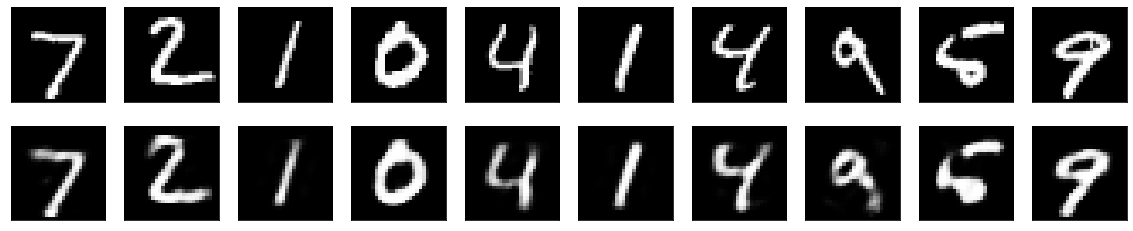

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
